In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import triton
import original_quant
import quant

## Verify corectness

In [2]:
# Verify various values for M to ensure correctness with all kinds of context lengths
for M in [8, 100, 256, 2048]:
	M = M # B * seq_len
	K = 4096 # Input dimension
	N = 4096 # Output dimension

	torch.manual_seed(0)
	layer = nn.Linear(K, N)
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cudalayer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cudalayer.pack(layer, quantizer.scale, quantizer.zero)

	tritonlayer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	state_dict = cudalayer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
	tritonlayer.load_state_dict(state_dict)

	layer = layer.half()

	layer = layer.to('cuda')
	cudalayer = cudalayer.to('cuda')
	tritonlayer = tritonlayer.to('cuda')

	ref = layer(vec)
	cuda_out = cudalayer(vec)
	triton_out = tritonlayer(vec)

	print(f'[{M}, {K}] -> [{M}, {N}]')
	print(f'cuda_out - ref: {(cuda_out - ref).abs().max()}')
	print(f'triton_out - ref: {(triton_out - ref).abs().max()}')
	print(f'triton_out - cuda_out: {(triton_out - cuda_out).abs().max()}')

[8, 4096] -> [8, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.001953125
triton_out - cuda_out: 0.001953125
[100, 4096] -> [100, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.00390625
triton_out - cuda_out: 0.001953125
[256, 4096] -> [256, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.00390625
triton_out - cuda_out: 0.001953125
[2048, 4096] -> [2048, 4096]
cuda_out - ref: 0.001953125
triton_out - ref: 0.00390625
triton_out - cuda_out: 0.00390625


## Benchmark Kernel
Tests the speed of the Triton, CUDA, and FP16 kernels on 4096x4096 and 4096x11008 matrices.

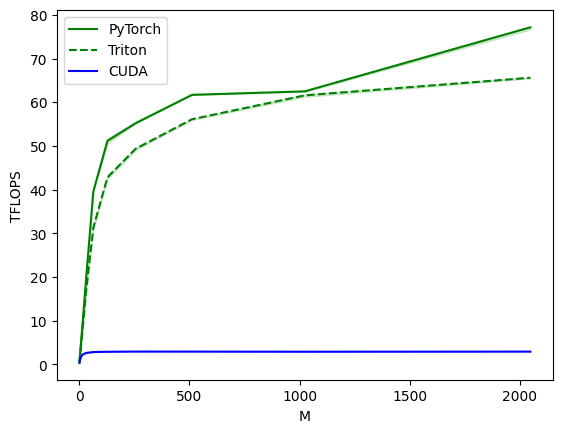

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.668735   0.564966  0.364089
1      2.0   1.260308   1.092267  0.697191
2      4.0   2.520615   2.184533  1.149754
3      8.0   5.041231   4.369067  1.747627
4     16.0   9.892226   8.594885  2.299509
5     32.0  20.164923  17.189771  2.647919
6     64.0  39.568906  31.300776  2.845525
7    128.0  51.150050  42.799022  2.902633
8    256.0  55.188213  49.344753  2.950618
9    512.0  61.680940  56.111089  2.944404
10  1024.0  62.484974  61.567763  2.915242
11  2048.0  77.136626  65.600063  2.943952


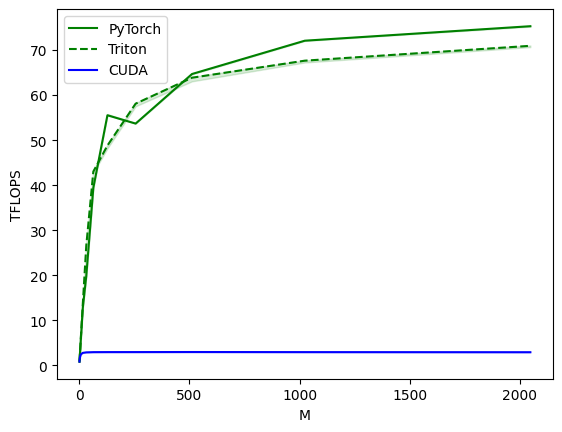

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.759172   0.863373  0.830792
1      2.0   1.601164   1.693538  1.354831
2      4.0   3.202327   3.387077  1.946166
3      8.0   6.404654   6.709638  2.454746
4     16.0  12.693910  13.419276  2.752000
5     32.0  19.845408  26.585359  2.868242
6     64.0  39.413259  43.023636  2.917234
7    128.0  55.528039  48.797368  2.928222
8    256.0  53.677105  58.104085  2.931649
9    512.0  64.689767  63.865109  2.944765
10  1024.0  72.084362  67.650063  2.924424
11  2048.0  75.304829  70.950067  2.902913


In [2]:
def benchmarker(M, N, provider):
	layer = nn.Linear(4096, N)
	vec = torch.randn(M, 4096, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cuda_layer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cuda_layer.pack(layer, quantizer.scale, quantizer.zero)

	# Convert layer to 16-bit
	layer = layer.half()

	# Convert cuda_layer to Triton
	state_dict = cuda_layer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	state_dict['bias'] = state_dict['bias'].to(torch.float16, copy=True)
	triton_layer = quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	triton_layer.load_state_dict(state_dict)

	# Move to GPU
	layer = layer.to('cuda')
	cuda_layer = cuda_layer.to('cuda')
	triton_layer = triton_layer.to('cuda')

	if provider == 'torch':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_layer(vec))
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_layer(vec))
	
	perf = lambda ms: 2 * M * N * 4096 * 1e-12 / (ms * 1e-3)
	return perf(ms), perf(max_ms), perf(min_ms)


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

benchmark.run(show_plots=True, print_data=True)


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 11008, provider)

benchmark.run(show_plots=True, print_data=True)

## Config Usage
Print out the kernel configurations used by the above code.  Useful for determining which configurations are useful on a given GPU.

In [6]:
from quant import matmul4_kernel

print("Used kernel configs:")
configs = set(str(x) for x in matmul4_kernel.cache.values())
for config in configs:
	print(str(config))

Used kernel configs:
BLOCK_SIZE_M: 128, BLOCK_SIZE_N: 128, BLOCK_SIZE_K: 32, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 256, BLOCK_SIZE_K: 32, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 128, BLOCK_SIZE_K: 32, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 32, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 64, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 32, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 128, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 32, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 64, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 32, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 32, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 32, GROUP_SIZE_M: 8, num_warps: 4, num_stages: 4
BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 64, GROUP_SIZE_M: 8, num_warps: 4